In [50]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8459282304254608270
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2915486926
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7925718885222466122
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [51]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
def rename(folder):
   
    for count, filename in enumerate(os.listdir(folder)):
        if count<10:
            new_name = f"00{str(count)}.jpg"
        elif count<100:
            new_name = f"0{str(count)}.jpg"
        else:
            new_name = f"{str(count)}.jpg"
            
        old_name =f"{folder}/{filename}"
        new_name =f"{folder}/{new_name}"

        os.rename(old_name, new_name)

In [4]:
rename("C:/Users/Saberi/Desktop/NN/3/photos")

rename("C:/Users/Saberi/Desktop/NN/3/sketches")

In [54]:
feret_list = []

for filename in sorted(glob.glob('C:/Users/Saberi/Desktop/NN/3/cufsf/feret_images/*.tif')):
    im=cv2.imread(filename,0)
    im=cv2.resize(im, (128,128))
    feret_list.append(im)
    
feret_sketch_list= []

for filename in sorted(glob.glob('C:/Users/Saberi/Desktop/NN/3/cufsf/original_sketch/*.jpg')):
    im=cv2.imread(filename,0)
    im=cv2.resize(im, (168,160))
    feret_sketch_list.append(im)

In [55]:
len(feret_sketch_list)

1194

In [56]:
feret_sketch=np.array([i[15:143,20:148] for i in feret_sketch_list]).reshape((1194, 128, 128,1))
feret=np.array(feret_list).reshape((1194, 128, 128,1))

In [57]:
print(feret_sketch.shape)
print(feret.shape)

(1194, 128, 128, 1)
(1194, 128, 128, 1)


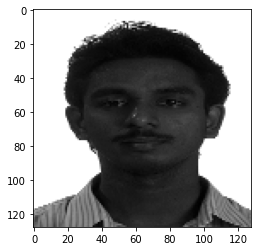

In [58]:
plt.imshow(feret[574],cmap="gray")
plt.show()

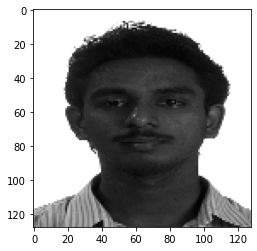

In [59]:
plt.imshow(cv2.normalize(feret, None, alpha=0,beta=300, norm_type=cv2.NORM_MINMAX)[574],cmap="gray")
plt.show()

In [60]:
feret=cv2.normalize(feret, None, alpha=0,beta=300, norm_type=cv2.NORM_MINMAX)

In [61]:
def get_gray_pic(photo,num1,num2,title):
    samp=(photo)[num1:num2]
    num=len(samp)
    fig, axes = plt.subplots(nrows=1, ncols=num,figsize=(15,15))
    for j in range(0,(num)):
        img = samp[j,:,:,0]
        axes[j].imshow(img,cmap='gray')
        axes[j].axis('off')
    
    axes[((num-1)//2)].set_title(f"{num} samples of {title}",loc='center')    

    plt.show()

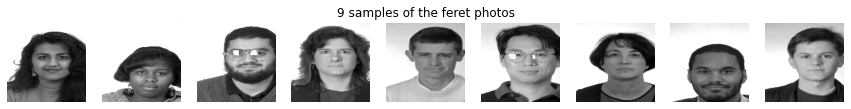

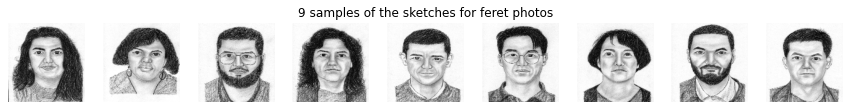

In [62]:
get_gray_pic(feret,100,109,"the feret photos")
get_gray_pic(feret_sketch,100,109,"the sketches for feret photos")

In [63]:
flip_photo=np.concatenate((feret,tf.image.flip_left_right(feret)))

In [64]:
flip_sketch=np.concatenate((feret_sketch,tf.image.flip_left_right(feret_sketch)))

In [65]:
print(flip_photo.shape, flip_sketch.shape)

(2388, 128, 128, 1) (2388, 128, 128, 1)


In [66]:
rot1_photo = np.concatenate((flip_photo,tfa.image.rotate(flip_photo, tf.constant(np.pi/8))))

In [67]:
rot1_sketch= np.concatenate((flip_sketch,tfa.image.rotate(flip_sketch, tf.constant(np.pi/8))))

In [68]:
print(rot1_photo.shape,rot1_sketch.shape)

(4776, 128, 128, 1) (4776, 128, 128, 1)


In [69]:
rot2_photo = np.concatenate((rot1_photo,tfa.image.rotate(flip_photo, tf.constant(-np.pi/8))))

In [70]:
rot2_sketch = np.concatenate((rot1_sketch,tfa.image.rotate(flip_sketch, tf.constant(-np.pi/8))))

In [71]:
print(rot2_photo.shape,rot2_sketch.shape)

(7164, 128, 128, 1) (7164, 128, 128, 1)


In [72]:
photo_shuffled,sketch_shuffled = shuffle(rot2_photo, rot2_sketch, random_state=0)

In [73]:
photo_shuffled=photo_shuffled/255.
sketch_shuffled=sketch_shuffled/255.

In [74]:
train_photo, test_photo, train_sketch, test_sketch = train_test_split(photo_shuffled, sketch_shuffled, test_size=0.02, random_state=42)

In [75]:
print(train_photo.shape)
print(train_sketch.shape)
print(test_photo.shape)
print(test_sketch.shape)

(7020, 128, 128, 1)
(7020, 128, 128, 1)
(144, 128, 128, 1)
(144, 128, 128, 1)


In [76]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.039154688

In [77]:
del photo_shuffled
del sketch_shuffled
del rot2_photo
del rot2_sketch
del rot1_photo
del rot1_sketch
del flip_photo
del flip_sketch
del feret
del feret_sketch
del feret_list
del feret_sketch_list

In [78]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.039154688

___________

### Model fitting

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Dropout,Input,Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [83]:
input = Input(shape=train_photo.shape[1:])

# Encoder
x = Conv2D(16, (4, 4), activation="relu",strides = 2, use_bias = False)(input)
x = Conv2D(32, (4, 4), activation="relu", strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(512, (2, 2), activation="relu",strides = 1, use_bias = False)(x)
x = BatchNormalization()(x)
# Decoder
x = Conv2DTranspose(512, (2, 2), strides=1, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)

x = Conv2DTranspose(256, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, (4, 4), strides=2,  activation="relu", use_bias = False)(x)
x = Conv2DTranspose(32, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(16, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(8, (2, 2), strides=1,   activation="relu",  padding = 'valid')(x)
x = Conv2DTranspose(1, (2, 2), strides=1,   activation="sigmoid",  padding = 'valid')(x)

# Autoencoder
autoencoder = Model(input, x)

adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

autoencoder.compile(optimizer=adam, loss="binary_crossentropy")

autoencoder.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_59 (Conv2D)          (None, 63, 63, 16)        256       
                                                                 
 conv2d_60 (Conv2D)          (None, 30, 30, 32)        8192      
                                                                 
 batch_normalization_37 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 14, 14, 64)        32768     
                                                                 
 conv2d_62 (Conv2D)          (None, 6, 6, 128)         131072    
                                                           

In [84]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.056662272

In [85]:
history=autoencoder.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.01)

Epoch 1/100
218/218 [==============================] - 20s 71ms/step - loss: 0.4859 - val_loss: 0.4685
Epoch 2/100
218/218 [==============================] - 14s 66ms/step - loss: 0.4141 - val_loss: 0.4110
Epoch 3/100
218/218 [==============================] - 14s 65ms/step - loss: 0.4090 - val_loss: 0.4099
Epoch 4/100
218/218 [==============================] - 14s 66ms/step - loss: 0.4049 - val_loss: 0.4333
Epoch 5/100
218/218 [==============================] - 14s 65ms/step - loss: 0.4049 - val_loss: 0.4140
Epoch 6/100
218/218 [==============================] - 14s 66ms/step - loss: 0.4005 - val_loss: 0.4038
Epoch 7/100
218/218 [==============================] - 14s 66ms/step - loss: 0.4002 - val_loss: 0.4066
Epoch 8/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3978 - val_loss: 0.4036
Epoch 9/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3960 - val_loss: 0.4062
Epoch 10/100
218/218 [==============================] - 15s 67ms/step - l

Epoch 80/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3621 - val_loss: 0.4018
Epoch 81/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3621 - val_loss: 0.4027
Epoch 82/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3622 - val_loss: 0.4014
Epoch 83/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3620 - val_loss: 0.4081
Epoch 84/100
218/218 [==============================] - 15s 67ms/step - loss: 0.3654 - val_loss: 0.4014
Epoch 85/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3630 - val_loss: 0.4022
Epoch 86/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3620 - val_loss: 0.4019
Epoch 87/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3619 - val_loss: 0.4039
Epoch 88/100
218/218 [==============================] - 14s 66ms/step - loss: 0.3626 - val_loss: 0.4014
Epoch 89/100
218/218 [==============================] - 14s 66ms

In [86]:
pred= autoencoder.predict(test_photo)

5/5 [==============================] - 1s 104ms/step


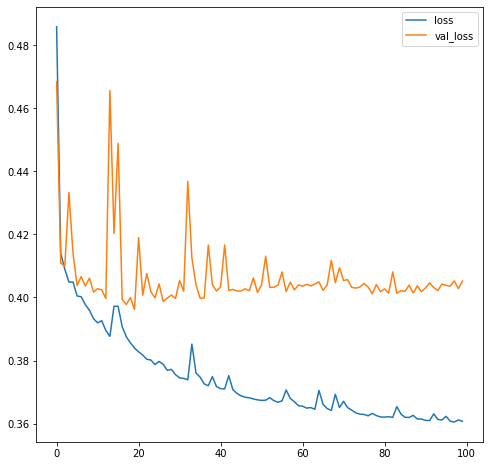

In [87]:
plt.figure(figsize=(8,8))
plt.plot(history.history["loss"][::])
plt.plot(history.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

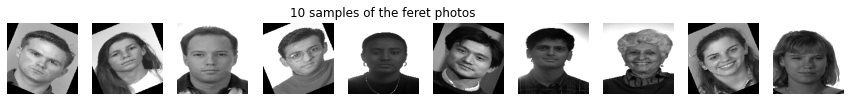

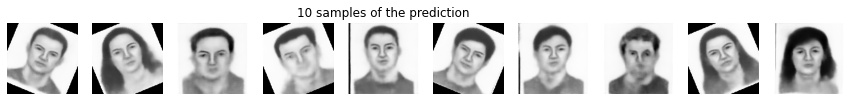

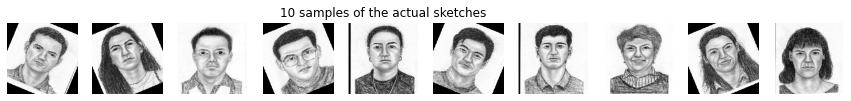

In [88]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

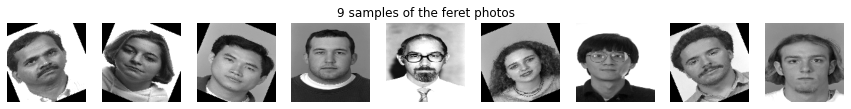

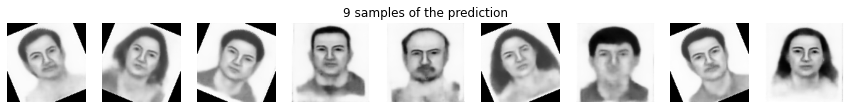

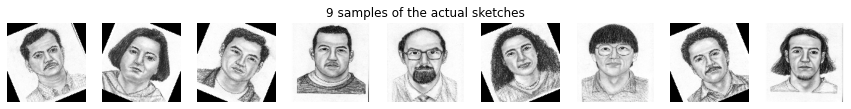

In [89]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

In [91]:
input = Input(shape=train_photo.shape[1:])

# Encoder
x = Conv2D(32, (4, 4), activation="relu",strides = 2, use_bias = False)(input)
x = Conv2D(32, (4, 4), activation="relu", strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(512, (2, 2), activation="relu",strides = 1, use_bias = False)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(512, (2, 2), strides=1, activation="relu", use_bias = False)(x)
x = Dropout(0.3)(x)

x = Conv2DTranspose(256, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, (4, 4), strides=2,  activation="relu", use_bias = False)(x)
x = Conv2DTranspose(32, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(16, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(8, (2, 2), strides=1,   activation="relu",  padding = 'valid')(x)
x = Conv2DTranspose(1, (2, 2), strides=1,   activation="sigmoid",  padding = 'valid')(x)

# Autoencoder
autoencoder2 = Model(input, x)

adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

autoencoder2.compile(optimizer=adam, loss="mean_absolute_error")

autoencoder2.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_71 (Conv2D)          (None, 63, 63, 32)        512       
                                                                 
 conv2d_72 (Conv2D)          (None, 30, 30, 32)        16384     
                                                                 
 batch_normalization_45 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_73 (Conv2D)          (None, 14, 14, 64)        32768     
                                                                 
 conv2d_74 (Conv2D)          (None, 6, 6, 128)         131072    
                                                           

In [92]:
history2=autoencoder2.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.01)

Epoch 1/100
218/218 [==============================] - 16s 69ms/step - loss: 0.1830 - val_loss: 0.2179
Epoch 2/100
218/218 [==============================] - 15s 70ms/step - loss: 0.1078 - val_loss: 0.1597
Epoch 3/100
218/218 [==============================] - 15s 69ms/step - loss: 0.1027 - val_loss: 0.1065
Epoch 4/100
218/218 [==============================] - 15s 69ms/step - loss: 0.1006 - val_loss: 0.1043
Epoch 5/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0983 - val_loss: 0.0986
Epoch 6/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0969 - val_loss: 0.1013
Epoch 7/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0954 - val_loss: 0.0983
Epoch 8/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0940 - val_loss: 0.1014
Epoch 9/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0931 - val_loss: 0.1018
Epoch 10/100
218/218 [==============================] - 15s 67ms/step - l

Epoch 80/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0638 - val_loss: 0.0927
Epoch 81/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0636 - val_loss: 0.0929
Epoch 82/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0635 - val_loss: 0.0927
Epoch 83/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0647 - val_loss: 0.0933
Epoch 84/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0638 - val_loss: 0.0933
Epoch 85/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0635 - val_loss: 0.0919
Epoch 86/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0632 - val_loss: 0.0918
Epoch 87/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0628 - val_loss: 0.0921
Epoch 88/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0627 - val_loss: 0.0930
Epoch 89/100
218/218 [==============================] - 15s 68ms

In [93]:
pred2= autoencoder2.predict(test_photo)

5/5 [==============================] - 0s 36ms/step


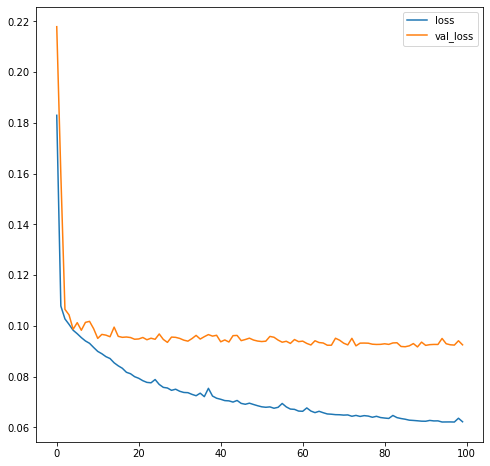

In [94]:
plt.figure(figsize=(8,8))
plt.plot(history2.history["loss"][::])
plt.plot(history2.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

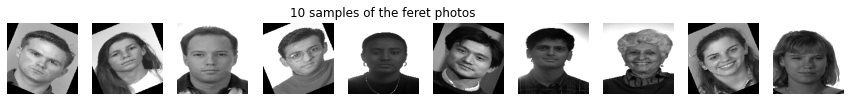

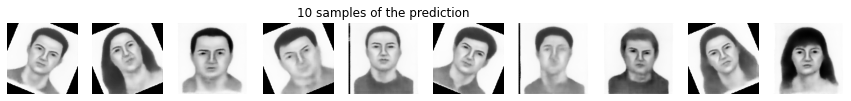

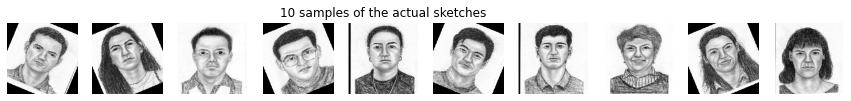

In [95]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred2,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

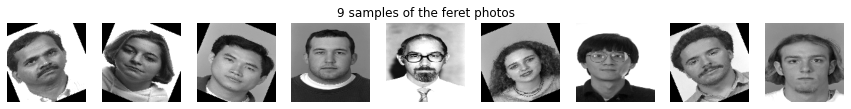

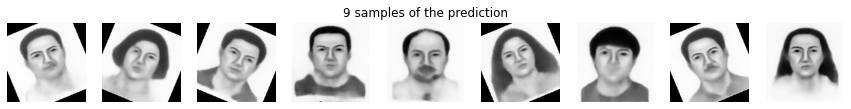

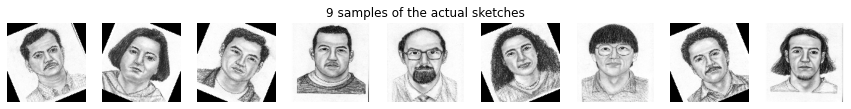

In [96]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred2,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

In [97]:
input = Input(shape=train_photo.shape[1:])

# Encoder
x = Conv2D(32, (4, 4), activation="relu",strides = 2, use_bias = False)(input)
x = Conv2D(32, (4, 4), activation="relu", strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(512, (2, 2), activation="relu",strides = 1, use_bias = False)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2DTranspose(512, (2, 2), strides=1, activation="relu", use_bias = False)(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(256, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, (4, 4), strides=2,  activation="relu", use_bias = False)(x)
x = Conv2DTranspose(32, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(16, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(8, (2, 2), strides=1,   activation="relu",  padding = 'valid')(x)
x = Conv2DTranspose(1, (2, 2), strides=1,   activation="sigmoid",  padding = 'valid')(x)

# Autoencoder
autoencoder3 = Model(input, x)

adam=Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)

autoencoder3.compile(optimizer=adam, loss="mean_absolute_error")

autoencoder3.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_77 (Conv2D)          (None, 63, 63, 32)        512       
                                                                 
 conv2d_78 (Conv2D)          (None, 30, 30, 32)        16384     
                                                                 
 batch_normalization_49 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_79 (Conv2D)          (None, 14, 14, 64)        32768     
                                                                 
 conv2d_80 (Conv2D)          (None, 6, 6, 128)         131072    
                                                          

In [98]:
history3=autoencoder3.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.01)

Epoch 1/100
218/218 [==============================] - 16s 69ms/step - loss: 0.1675 - val_loss: 0.2436
Epoch 2/100
218/218 [==============================] - 15s 68ms/step - loss: 0.1118 - val_loss: 0.1186
Epoch 3/100
218/218 [==============================] - 15s 68ms/step - loss: 0.1069 - val_loss: 0.1066
Epoch 4/100
218/218 [==============================] - 15s 68ms/step - loss: 0.1046 - val_loss: 0.1098
Epoch 5/100
218/218 [==============================] - 15s 68ms/step - loss: 0.1032 - val_loss: 0.1100
Epoch 6/100
218/218 [==============================] - 15s 71ms/step - loss: 0.1015 - val_loss: 0.1007
Epoch 7/100
218/218 [==============================] - 15s 68ms/step - loss: 0.1002 - val_loss: 0.1000
Epoch 8/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0996 - val_loss: 0.1068
Epoch 9/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0985 - val_loss: 0.0987
Epoch 10/100
218/218 [==============================] - 15s 68ms/step - l

Epoch 80/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0734 - val_loss: 0.0951
Epoch 81/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0735 - val_loss: 0.0944
Epoch 82/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0731 - val_loss: 0.0960
Epoch 83/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0733 - val_loss: 0.0946
Epoch 84/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0732 - val_loss: 0.0954
Epoch 85/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0734 - val_loss: 0.0958
Epoch 86/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0730 - val_loss: 0.0951
Epoch 87/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0729 - val_loss: 0.0956
Epoch 88/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0727 - val_loss: 0.0955
Epoch 89/100
218/218 [==============================] - 15s 68ms

In [99]:
pred3= autoencoder3.predict(test_photo)

5/5 [==============================] - 0s 34ms/step


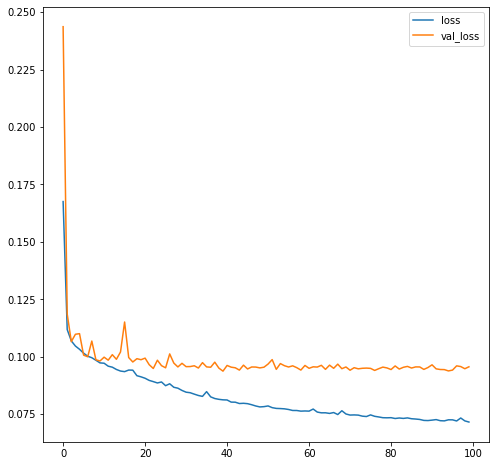

In [104]:
plt.figure(figsize=(8,8))
plt.plot(history3.history["loss"][::])
plt.plot(history3.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

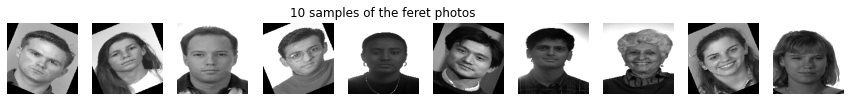

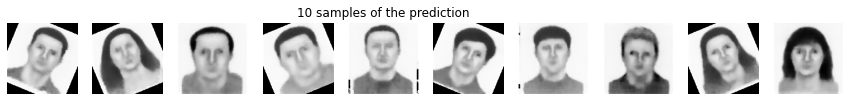

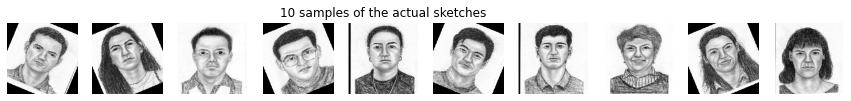

In [101]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred3,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

In [102]:
input = Input(shape=train_photo.shape[1:])

# Encoder
x = Conv2D(64, (4, 4), activation="relu",strides = 2, use_bias = False)(input)
x = Conv2D(64, (4, 4), activation="relu", strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(512, (2, 2), activation="relu",strides = 1, use_bias = False)(x)
x = BatchNormalization()(x)


x = Conv2DTranspose(512, (2, 2), strides=1, activation="relu", use_bias = False)(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(256, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, (4, 4), strides=2,  activation="relu", use_bias = False)(x)
x = Conv2DTranspose(32, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(16, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(8, (2, 2), strides=1,   activation="relu",  padding = 'valid')(x)
x = Conv2DTranspose(1, (2, 2), strides=1,   activation="sigmoid",  padding = 'valid')(x)

# Autoencoder
autoencoder4 = Model(input, x)

adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

autoencoder4.compile(optimizer=adam, loss="mean_absolute_error")

autoencoder4.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_83 (Conv2D)          (None, 63, 63, 64)        1024      
                                                                 
 conv2d_84 (Conv2D)          (None, 30, 30, 64)        65536     
                                                                 
 batch_normalization_53 (Bat  (None, 30, 30, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_85 (Conv2D)          (None, 14, 14, 128)       131072    
                                                                 
 dropout_25 (Dropout)        (None, 14, 14, 128)       0         
                                                          

In [103]:
history4=autoencoder4.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.01)

Epoch 1/100
218/218 [==============================] - 19s 84ms/step - loss: 0.1720 - val_loss: 0.1544
Epoch 2/100
218/218 [==============================] - 18s 81ms/step - loss: 0.1084 - val_loss: 0.1156
Epoch 3/100
218/218 [==============================] - 18s 85ms/step - loss: 0.1038 - val_loss: 0.1174
Epoch 4/100
218/218 [==============================] - 18s 83ms/step - loss: 0.1013 - val_loss: 0.1146
Epoch 5/100
218/218 [==============================] - 18s 82ms/step - loss: 0.0993 - val_loss: 0.1072
Epoch 6/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0976 - val_loss: 0.0996
Epoch 7/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0962 - val_loss: 0.1036
Epoch 8/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0963 - val_loss: 0.1005
Epoch 9/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0937 - val_loss: 0.0994
Epoch 10/100
218/218 [==============================] - 18s 81ms/step - l

Epoch 80/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0648 - val_loss: 0.0922
Epoch 81/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0644 - val_loss: 0.0905
Epoch 82/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0646 - val_loss: 0.0912
Epoch 83/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0643 - val_loss: 0.0912
Epoch 84/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0642 - val_loss: 0.0913
Epoch 85/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0640 - val_loss: 0.0914
Epoch 86/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0638 - val_loss: 0.0911
Epoch 87/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0642 - val_loss: 0.0913
Epoch 88/100
218/218 [==============================] - 18s 81ms/step - loss: 0.0642 - val_loss: 0.0910
Epoch 89/100
218/218 [==============================] - 18s 81ms

In [105]:
pred4= autoencoder4.predict(test_photo)

5/5 [==============================] - 0s 50ms/step


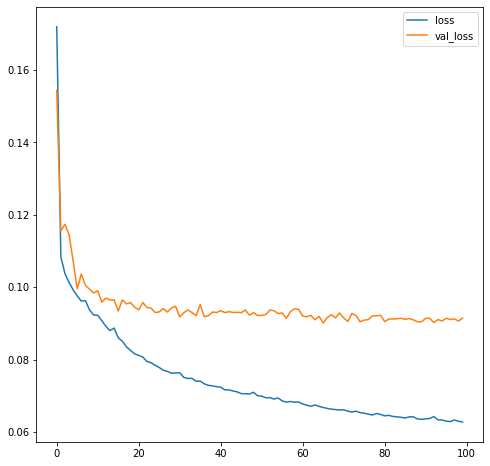

In [106]:
plt.figure(figsize=(8,8))
plt.plot(history4.history["loss"][::])
plt.plot(history4.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

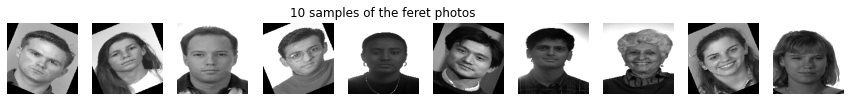

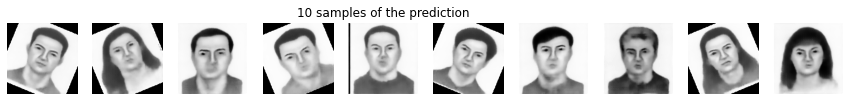

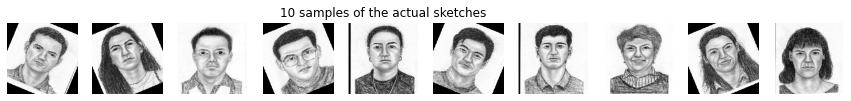

In [107]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred4,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

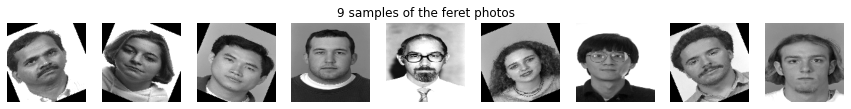

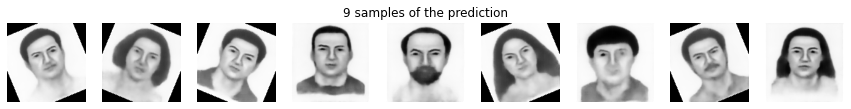

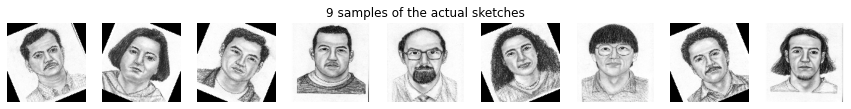

In [108]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred4,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

In [109]:
history5=autoencoder4.fit(x=train_photo,y=train_sketch,epochs=200,batch_size = 32, validation_split= 0.01)

Epoch 1/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0629 - val_loss: 0.0931
Epoch 2/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0628 - val_loss: 0.0908
Epoch 3/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0624 - val_loss: 0.0905
Epoch 4/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0625 - val_loss: 0.0911
Epoch 5/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0626 - val_loss: 0.0912
Epoch 6/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0622 - val_loss: 0.0918
Epoch 7/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0621 - val_loss: 0.0911
Epoch 8/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0619 - val_loss: 0.0912
Epoch 9/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0623 - val_loss: 0.0915
Epoch 10/200
218/218 [==============================] - 18s 82ms/step - l

Epoch 80/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0593 - val_loss: 0.0902
Epoch 81/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0593 - val_loss: 0.0900
Epoch 82/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0593 - val_loss: 0.0905
Epoch 83/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0590 - val_loss: 0.0900
Epoch 84/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0591 - val_loss: 0.0900
Epoch 85/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0590 - val_loss: 0.0904
Epoch 86/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0590 - val_loss: 0.0903
Epoch 87/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0589 - val_loss: 0.0903
Epoch 88/200
218/218 [==============================] - 18s 82ms/step - loss: 0.0588 - val_loss: 0.0902
Epoch 89/200
218/218 [==============================] - 18s 82ms

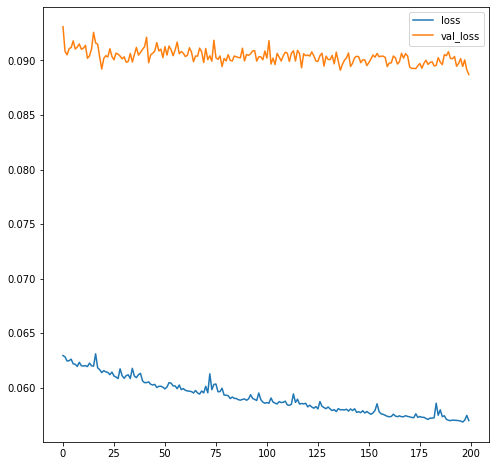

In [110]:
plt.figure(figsize=(8,8))
plt.plot(history5.history["loss"][::])
plt.plot(history5.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

In [111]:
pred5= autoencoder4.predict(test_photo)

5/5 [==============================] - 0s 37ms/step


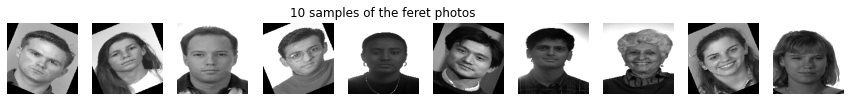

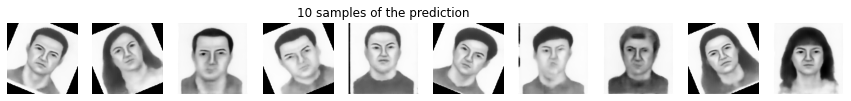

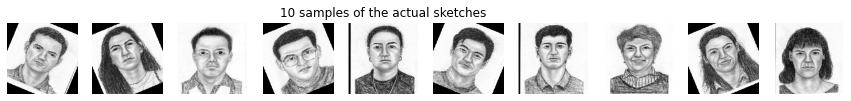

In [112]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred5,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

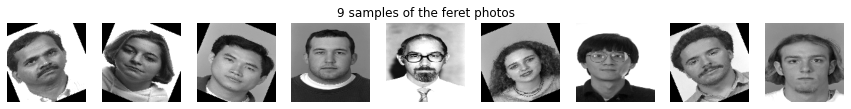

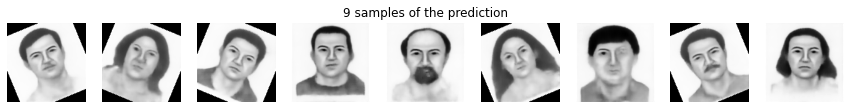

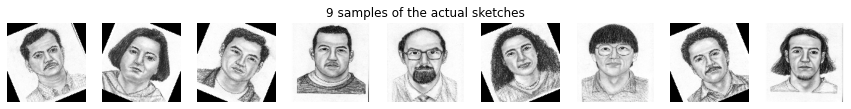

In [113]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred5,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

In [114]:
history6=autoencoder2.fit(x=train_photo,y=train_sketch,epochs=200,batch_size = 32, validation_split= 0.01)

Epoch 1/200
218/218 [==============================] - 15s 68ms/step - loss: 0.0619 - val_loss: 0.0923
Epoch 2/200
218/218 [==============================] - 15s 68ms/step - loss: 0.0619 - val_loss: 0.0916
Epoch 3/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0616 - val_loss: 0.0922
Epoch 4/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0615 - val_loss: 0.0919
Epoch 5/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0613 - val_loss: 0.0921
Epoch 6/200
218/218 [==============================] - 15s 68ms/step - loss: 0.0616 - val_loss: 0.0916
Epoch 7/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0613 - val_loss: 0.0946
Epoch 8/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0614 - val_loss: 0.0935
Epoch 9/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0627 - val_loss: 0.0927
Epoch 10/200
218/218 [==============================] - 15s 67ms/step - l

Epoch 80/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0582 - val_loss: 0.0918
Epoch 81/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0584 - val_loss: 0.0919
Epoch 82/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0581 - val_loss: 0.0917
Epoch 83/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0582 - val_loss: 0.0917
Epoch 84/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0597 - val_loss: 0.0922
Epoch 85/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0590 - val_loss: 0.0922
Epoch 86/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0584 - val_loss: 0.0914
Epoch 87/200
218/218 [==============================] - 15s 68ms/step - loss: 0.0581 - val_loss: 0.0916
Epoch 88/200
218/218 [==============================] - 15s 67ms/step - loss: 0.0581 - val_loss: 0.0918
Epoch 89/200
218/218 [==============================] - 15s 67ms

In [115]:
pred6= autoencoder2.predict(test_photo)

5/5 [==============================] - 0s 37ms/step


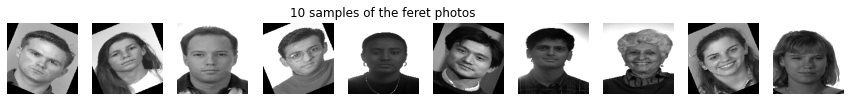

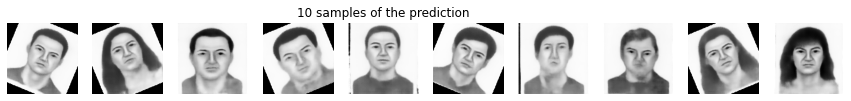

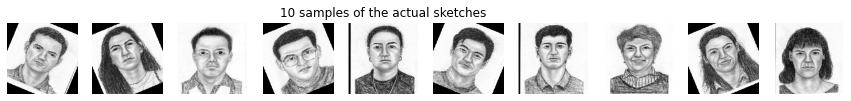

In [116]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred6,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

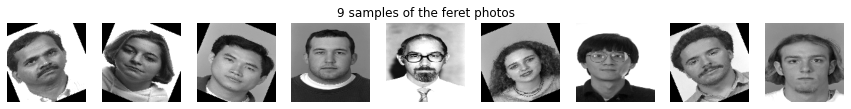

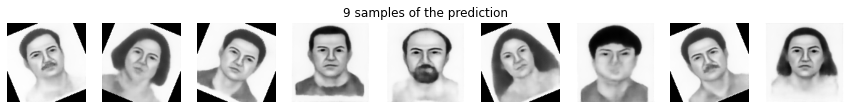

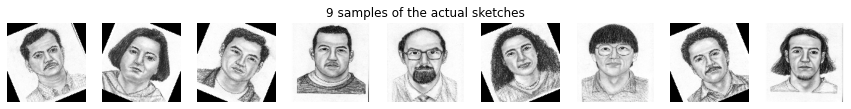

In [117]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred6,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

In [200]:
history7=autoencoder3.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.01)

Epoch 1/100
218/218 [==============================] - 15s 69ms/step - loss: 0.0720 - val_loss: 0.0949
Epoch 2/100
218/218 [==============================] - 14s 66ms/step - loss: 0.0716 - val_loss: 0.0947
Epoch 3/100
218/218 [==============================] - 14s 65ms/step - loss: 0.0712 - val_loss: 0.0957
Epoch 4/100
218/218 [==============================] - 14s 66ms/step - loss: 0.0716 - val_loss: 0.0940
Epoch 5/100
218/218 [==============================] - 15s 70ms/step - loss: 0.0710 - val_loss: 0.0949
Epoch 6/100
218/218 [==============================] - 17s 77ms/step - loss: 0.0710 - val_loss: 0.0946
Epoch 7/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0709 - val_loss: 0.0954
Epoch 8/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0707 - val_loss: 0.0948
Epoch 9/100
218/218 [==============================] - 17s 78ms/step - loss: 0.0710 - val_loss: 0.0960
Epoch 10/100
218/218 [==============================] - 17s 76ms/step - l

Epoch 80/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0677 - val_loss: 0.0950
Epoch 81/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0684 - val_loss: 0.0934
Epoch 82/100
218/218 [==============================] - 15s 68ms/step - loss: 0.0681 - val_loss: 0.0926
Epoch 83/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0678 - val_loss: 0.0928
Epoch 84/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0675 - val_loss: 0.0934
Epoch 85/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0702 - val_loss: 0.0922
Epoch 86/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0681 - val_loss: 0.0925
Epoch 87/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0680 - val_loss: 0.0923
Epoch 88/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0682 - val_loss: 0.0937
Epoch 89/100
218/218 [==============================] - 15s 67ms

In [231]:
new_im=cv2.imread("C:/Users/Saberi/Desktop/new.jpg",0)
new_im=cv2.resize(new_im, (128,128))

In [232]:
new_im.shape

(128, 128)

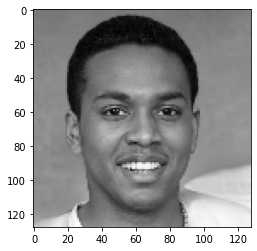

In [233]:
plt.imshow(new_im,cmap="gray")
plt.show()

In [234]:
new_im=new_im.reshape((128,128,1))

In [235]:
new_im=new_im.reshape((1,128, 128, 1))
new_im=new_im/255.

1/1 [==============================] - 0s 21ms/step


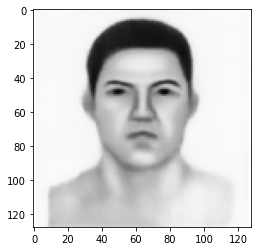

In [236]:
pred_new_im=autoencoder4.predict(new_im)
plt.imshow(pred_new_im[0,:,:,0],cmap="gray")
plt.show()

1/1 [==============================] - 0s 20ms/step


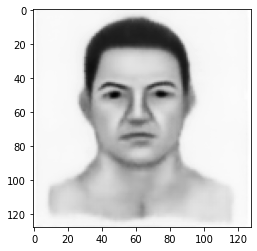

In [237]:
pred_new_im=autoencoder2.predict(new_im)
plt.imshow(pred_new_im[0,:,:,0],cmap="gray")
plt.show()

1/1 [==============================] - 0s 20ms/step


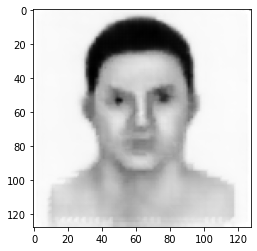

In [238]:
pred_new_im=autoencoder3.predict(new_im)
plt.imshow(pred_new_im[0,:,:,0],cmap="gray")
plt.show()

In [224]:
input = Input(shape=train_photo.shape[1:])
x = BatchNormalization()(x)
# Encoder
x = Conv2D(32, (4, 4), activation="relu", use_bias = False,padding="same")(input)
x = Conv2D(32, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Conv2D(64, (4, 4), activation="relu", strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (4, 4), activation="relu",strides = 2, use_bias = False)(x)
x = Dropout(0.3)(x)
x = Conv2D(512, (2, 2), activation="relu",strides = 1, use_bias = False)(x)
x = BatchNormalization()(x)


x = Conv2DTranspose(512, (2, 2), strides=1, activation="relu", use_bias = False)(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(256, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, (4, 4), strides=2,  activation="relu", use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(32, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(16, (4, 4), strides=2,  activation="relu",  use_bias = False)(x)
x = Conv2DTranspose(8, (2, 2), strides=1,   activation="relu",  padding = 'valid')(x)
x = Conv2DTranspose(1, (2, 2), strides=1,   activation="sigmoid",  padding = 'valid')(x)

# Autoencoder
autoencoder5 = Model(input, x)

adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

autoencoder5.compile(optimizer=adam, loss="mean_absolute_error")

autoencoder5.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 32)      512       
                                                                 
 conv2d_96 (Conv2D)          (None, 63, 63, 32)        16384     
                                                                 
 conv2d_97 (Conv2D)          (None, 30, 30, 64)        32768     
                                                                 
 batch_normalization_62 (Bat  (None, 30, 30, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_98 (Conv2D)          (None, 14, 14, 128)       131072    
                                                          

In [225]:
history8=autoencoder5.fit(x=train_photo,y=train_sketch,epochs=100,batch_size = 32, validation_split= 0.05)

Epoch 1/100
209/209 [==============================] - 23s 106ms/step - loss: 0.1822 - val_loss: 0.1788
Epoch 2/100
209/209 [==============================] - 21s 99ms/step - loss: 0.1108 - val_loss: 0.1134
Epoch 3/100
209/209 [==============================] - 21s 100ms/step - loss: 0.1064 - val_loss: 0.1083
Epoch 4/100
209/209 [==============================] - 21s 100ms/step - loss: 0.1040 - val_loss: 0.1033
Epoch 5/100
209/209 [==============================] - 21s 100ms/step - loss: 0.1016 - val_loss: 0.0996
Epoch 6/100
209/209 [==============================] - 21s 100ms/step - loss: 0.1003 - val_loss: 0.1009
Epoch 7/100
209/209 [==============================] - 21s 99ms/step - loss: 0.0991 - val_loss: 0.0981
Epoch 8/100
209/209 [==============================] - 21s 99ms/step - loss: 0.0982 - val_loss: 0.1176
Epoch 9/100
209/209 [==============================] - 21s 99ms/step - loss: 0.0970 - val_loss: 0.0966
Epoch 10/100
209/209 [==============================] - 21s 99ms/ste

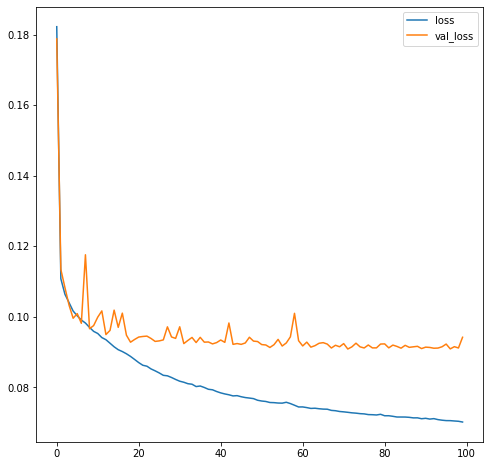

In [226]:
plt.figure(figsize=(8,8))
plt.plot(history8.history["loss"][::])
plt.plot(history8.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

In [227]:
pred8= autoencoder5.predict(test_photo)

5/5 [==============================] - 0s 60ms/step


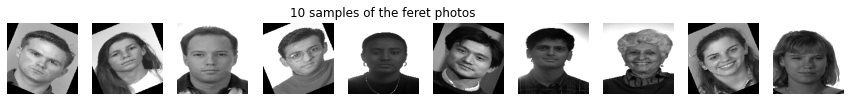

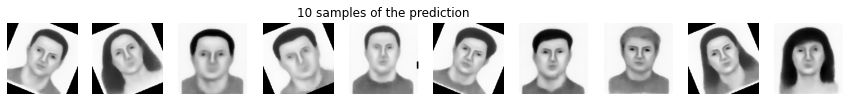

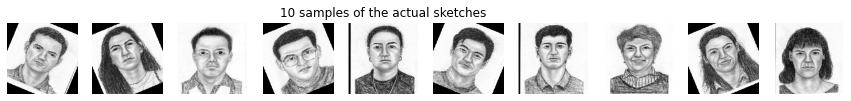

In [228]:
get_gray_pic(test_photo,0,10,"the feret photos")
get_gray_pic(pred8,0,10,"the prediction")
get_gray_pic(test_sketch,0,10,"the actual sketches")

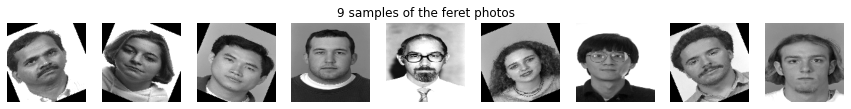

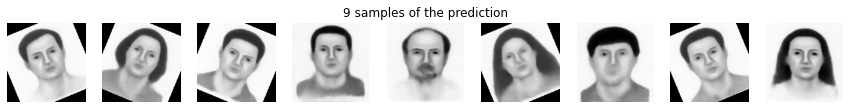

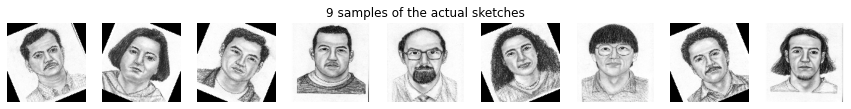

In [229]:
get_gray_pic(test_photo,11,20,"the feret photos")
get_gray_pic(pred8,11,20,"the prediction")
get_gray_pic(test_sketch,11,20,"the actual sketches")

1/1 [==============================] - 0s 18ms/step


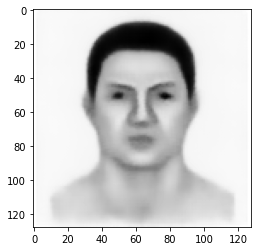

In [239]:
pred_new_im=autoencoder5.predict(new_im)
plt.imshow(pred_new_im[0,:,:,0],cmap="gray")
plt.show()